# Análise Exploratória dos Dados do IMDB

Neste Mini-Projeto foi feito uma análise exploratória de dados usando Linguagem Python, Linguagem SQL e Banco de Dados SQLite. 

Foram utilizados dados reais do IMDB disponíveis publicamente.

O objetivo dessa Análise Exploratória de Dados é responder as seguintes perguntas:

  1. Quais São as Categorias de Títulos Mais Comuns no IMDB?
  2. Qual o Número de Filmes Por Gênero?
  3. Qual a Mediana de Avaliação dos Filmes Por Gênero?
  4. Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?
  5. Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?
  6. Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.
  7. Qual a Relação Entre Duração e Gênero?
  8. Qual o Número de Filmes Produzidos Por País?
  9. Quais São os Top 10 Melhores Filmes?
  10. Quais São os Top 10 Piores Filmes?

## Instalando e Carregando Pacotes

In [ ]:
# Instala o pacote que permite pegar as bases do IMDB em banco SQLite
# https://pypi.org/project/imdb-sqlite/
%pip install -q imdb-sqlite

In [ ]:
# Instala o pacote que permite pegar os bancos de dados da ISO de países, subdivisões, língua, moeda e definições e traduções de scripts
# https://pypi.org/project/pycountry/
%pip install -q pycountry

In [1]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

## Carregando os Dados

In [2]:
%%time
!imdb-sqlite

2022-02-23 14:11:18,551 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 15.5 ms, sys: 32.9 ms, total: 48.4 ms
Wall time: 374 ms


In [3]:
conn = sqlite3.connect("imdb.db")

In [4]:
# Cria um dataframe com os nomes das tabelas do imdb.db
tables = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [5]:
print("Quatidade de tabelas: ", len(tables))
tables

Quatidade de tabelas:  6


,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes
5,ratings


In [6]:
# Converte o objeto de um dataframe para uma lista
tables = tables["Table_Name"].values.tolist()

In [7]:
# Mostra o esquema de cada tabela
for table in tables:
  query = "PRAGMA TABLE_INFO({})".format(table)
  res = pd.read_sql_query(query, conn)
  print("Esquema da tabela:", table)
  display(res)
  print("-" * 100)
  print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




## Análise Exploratória

### 1 - Quais São as Categorias de Títulos Mais Comuns no IMDB?

In [8]:
# Conta a quantidade de vezes que cada categoria aparece na tabela titles
query1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''
res1 = pd.read_sql_query(query1, conn)
display(res1)

,type,COUNT
0,movie,602608
1,short,856897
2,tvEpisode,6518779
3,tvMiniSeries,42195
4,tvMovie,135036
5,tvPilot,2
6,tvSeries,221441
7,tvShort,10457
8,tvSpecial,36012
9,video,257613


In [9]:
# Cria uma coluna "percentual" para facilitar a visualização dos dados
res1["percentual"] = (res1["COUNT"] / sum(res1["COUNT"])) * 100
display(res1)

,type,COUNT,percentual
0,movie,602608,6.917370
1,short,856897,9.836367
2,tvEpisode,6518779,74.829418
3,tvMiniSeries,42195,0.484359
4,tvMovie,135036,1.550086
5,tvPilot,2,0.000023
6,tvSeries,221441,2.541933
7,tvShort,10457,0.120036
8,tvSpecial,36012,0.413384
9,video,257613,2.957154


#### Gráfico com as 3 categorias mais relevantes mais uma categoria "outros" que engloba os demais tipos

In [10]:
# Cria um dicionário com a contagem e o percentual total das categorias menos relevantes
others = {}
others["COUNT"] = res1[res1["percentual"] < 5]["COUNT"].sum()
others["percentual"] = res1[res1["percentual"] < 5]["percentual"].sum()
others["type"] = "others"

In [11]:
others

{'COUNT': 733235, 'percentual': 8.41684441025727, 'type': 'others'}

In [12]:
# Filtra o dataframe res1
res1 = res1[res1["percentual"] > 5]

In [13]:
# Adiciona a categoria referente a "outros" e ordena o dataframe
res1 = res1.append(others, ignore_index=True)
res1 = res1.sort_values(by = "COUNT", ascending = False)

In [14]:
display(res1)

,type,COUNT,percentual
2,tvEpisode,6518779,74.829418
1,short,856897,9.836367
3,others,733235,8.416844
0,movie,602608,6.917370


In [15]:
# Ajusta as labels
labels = [str(res1["type"][i]) + " [" + str(round(res1["percentual"][i], 2)) + "%]" for i in res1.index]

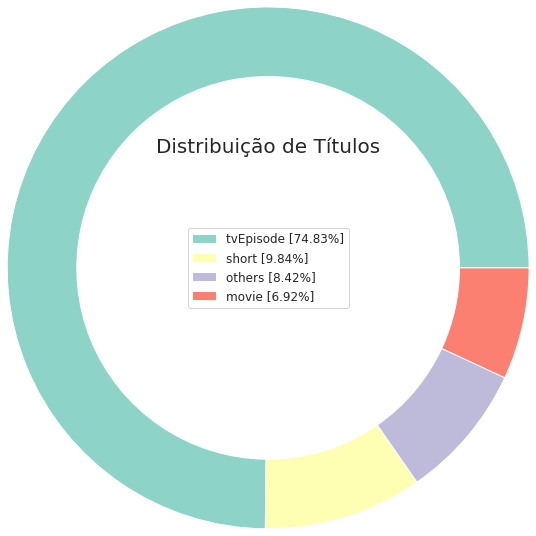

In [16]:
# Plot
cs = cm.Set3(np.arange(100))

fig = plt.figure()

plt.pie(res1["COUNT"], labeldistance=1, radius=3, colors=cs, wedgeprops=dict(width=0.8))
plt.legend(labels=labels, loc="center", prop={"size":12})
plt.title("Distribuição de Títulos", loc="Center", fontdict={"fontsize":20, "fontweight":20})
plt.show()

### 2 - Qual o Número de Filmes Por Gênero?

In [17]:
query2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''
res2 = pd.read_sql_query(query2, conn)
display(res2)

,genres,COUNT(*)
0,Action,13822
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1446,"Thriller,Western",42
1447,War,1287
1448,"War,Western",14
1449,Western,5101


In [18]:
# Coloca todos os valores da coluna "genres" em minúsculo
res2["genres"] = res2["genres"].str.lower().values

In [19]:
# Descarta valores faltantes
temp = res2["genres"].dropna()

In [20]:
# Usa o Countvectorizer para converter a coluna "genres" em um vetor one-hot encoded para contar o número de filmes em cada gênero
# Explicando a expressão regular (em ordem)
#   (?u)   ->  Unicode Matching
#   \b     ->  Espaço em branco antes de uma palavra
#   [\w-]+ ->  Várias palavras finalizadas ou não com hífen
#   \b     ->  Espaço em branco após uma palavra
re_pattern = "(?u)\\b[\\w-]+\\b"

vector = CountVectorizer(token_pattern=re_pattern, analyzer="word").fit(temp)

In [21]:
type(vector)

sklearn.feature_extraction.text.CountVectorizer

In [22]:
# Aplica a vetorização ao dataset sem valores NA
genres_bag = vector.transform(temp)

In [23]:
type(genres_bag)

scipy.sparse.csr.csr_matrix

In [24]:
# Retorna gêneros únicos
unique_genres = vector.get_feature_names()

In [25]:
# Cria o dataframe de gêneros
genres = pd.DataFrame(genres_bag.todense(), columns=unique_genres, index=temp.index)

In [26]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1450
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1451 non-null   int64
 1   adult        1451 non-null   int64
 2   adventure    1451 non-null   int64
 3   animation    1451 non-null   int64
 4   biography    1451 non-null   int64
 5   comedy       1451 non-null   int64
 6   crime        1451 non-null   int64
 7   documentary  1451 non-null   int64
 8   drama        1451 non-null   int64
 9   family       1451 non-null   int64
 10  fantasy      1451 non-null   int64
 11  film-noir    1451 non-null   int64
 12  game-show    1451 non-null   int64
 13  history      1451 non-null   int64
 14  horror       1451 non-null   int64
 15  music        1451 non-null   int64
 16  musical      1451 non-null   int64
 17  mystery      1451 non-null   int64
 18  n            1451 non-null   int64
 19  news         1451 non-null   int64
 20  reality-

In [27]:
display(genres)

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
# Drop da coluna n
genres = genres.drop(columns="n", axis=0)

#### Gráfico os Percentuais de Títulos por Gênero

In [29]:
# Calcula o percentual
genres_percentual = 100 * pd.Series(genres.sum()).sort_values(ascending=False) / genres.shape[0]

In [30]:
genres_percentual.head(10)

drama          18.194349
comedy         16.815989
documentary    15.851137
adventure      14.817367
action         14.403859
romance        13.370090
crime          13.094418
mystery        12.474156
thriller       12.336320
fantasy        12.198484
dtype: float64

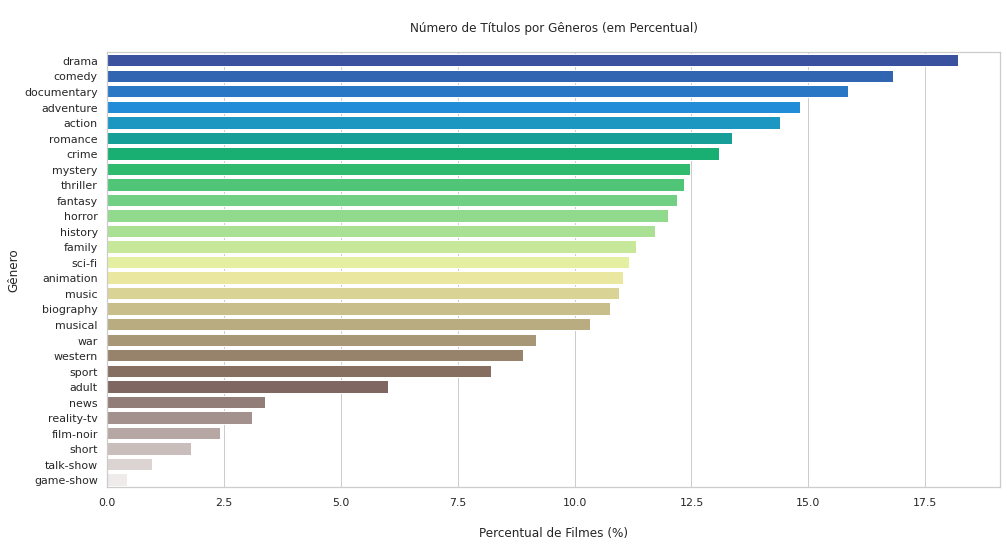

In [31]:
plt.figure(figsize=(16, 8))
sns.barplot(x=genres_percentual.values, y=genres_percentual.index, orient="h", palette="terrain")
plt.ylabel("Gênero")
plt.xlabel("\nPercentual de Filmes (%)")
plt.title("\nNúmero de Títulos por Gêneros (em Percentual)\n")
plt.show()


### 3 - Qual a Mediana de Avaliação dos Filmes Por Gênero?

In [32]:
query3 = '''
          SELECT rating, genres FROM 
          ratings JOIN titles ON ratings.title_id = titles.title_id 
          WHERE premiered <= 2022 AND type = 'movie'
        '''
res3 = pd.read_sql_query(query3, conn)
display(res3)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
275092,5.8,Thriller
275093,6.4,"Drama,History"
275094,3.8,"Adventure,History,War"
275095,8.3,Drama


In [33]:
# Função para encontrar os gêneros (Bem melhor do que fazer como na pergunta 2)
def return_genres(df):
  df["genres"] = df["genres"].str.lower().values
  temp = df["genres"].dropna()
  vector = CountVectorizer(token_pattern="(?u)\\b[\\w-]+\\b", analyzer="word").fit(temp)
  unique_genres = vector.get_feature_names()
  unique_genres = [genre for genre in unique_genres if len(genre) > 1]
  return unique_genres

In [34]:
unique_genres = return_genres(res3)

In [35]:
unique_genres

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [36]:
genre_counts = []
genre_rating = []

for item in unique_genres:
  # Retorna a contagem de filmes por gênero
  query = "SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '%" + item + "%' AND TYPE = 'movie'"
  res = pd.read_sql_query(query, conn)
  genre_counts.append(res.values[0][0])

  # Retorna a mediana das avaliações de filmes por gênero
  query = "SELECT rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '%" + item + "%' AND TYPE = 'movie'"
  res = pd.read_sql_query(query, conn)
  genre_rating.append(np.median(res["rating"]))

In [37]:
# Prepara o dataframe final
df_genre_ratings = pd.DataFrame()
df_genre_ratings["genres"] = unique_genres
df_genre_ratings["count"] = genre_counts
df_genre_ratings["rating"] = genre_rating

In [38]:
df_genre_ratings

,genres,count,rating
0,action,28513,5.80
1,adult,4298,5.90
2,adventure,17298,6.00
3,animation,4728,6.60
4,biography,8303,7.00
5,comedy,68157,6.00
6,crime,23485,6.10
7,documentary,40828,7.30
8,drama,121863,6.30
9,family,10647,6.30


In [39]:
df_genre_ratings = df_genre_ratings.drop(index=18)
df_genre_ratings = df_genre_ratings.sort_values(by="rating", ascending=False)

#### Plotando o Gráfico

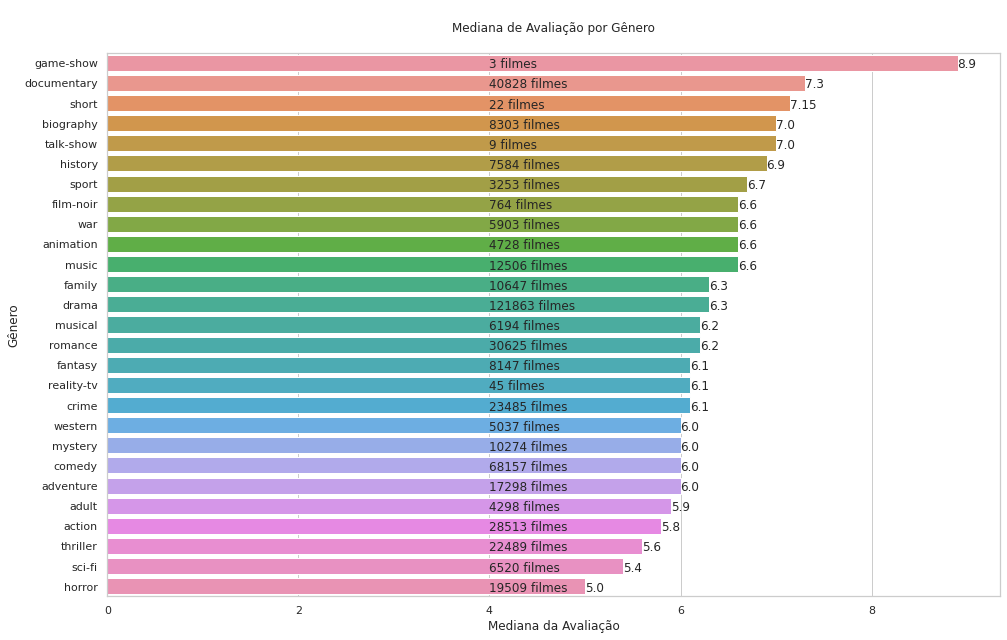

In [40]:
# Plot

plt.figure(figsize=(16, 10))

sns.barplot(y=df_genre_ratings.genres, x=df_genre_ratings.rating, orient="h")

for i in range(len(df_genre_ratings.index)):
  plt.text(4.0, i + 0.25, str(df_genre_ratings["count"][df_genre_ratings.index[i]]) + " filmes")
  plt.text(df_genre_ratings.rating[df_genre_ratings.index[i]], i + 0.25, round(df_genre_ratings["rating"][df_genre_ratings.index[i]], 2))

plt.ylabel("Gênero")
plt.xlabel("Mediana da Avaliação")
plt.title("\nMediana de Avaliação por Gênero\n")
plt.show()


### 4 - Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?

In [41]:
query4 = '''
          SELECT rating, premiered FROM
          ratings JOIN titles ON titles.title_id = ratings.title_id
          WHERE premiered <= 2022 AND type = 'movie'
          ORDER BY premiered
         '''
res4 = pd.read_sql_query(query4, conn)
display(res4)

,rating,premiered
0,6.2,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,6.0,1900
...,...,...
275092,7.0,2022
275093,3.7,2022
275094,4.1,2022
275095,6.1,2022


In [42]:
# Encontra a mediana por ano de estréia
ratings = []
for year in set(res4["premiered"]):
  ratings.append(np.median(res4[res4["premiered"] == year]["rating"]))

In [43]:
ratings[0:10]

[6.2, 4.5, 3.85, 5.85, 4.6, 3.5, 4.6, 5.4, 4.5, 3.6]

#### Plotando o Gráfico

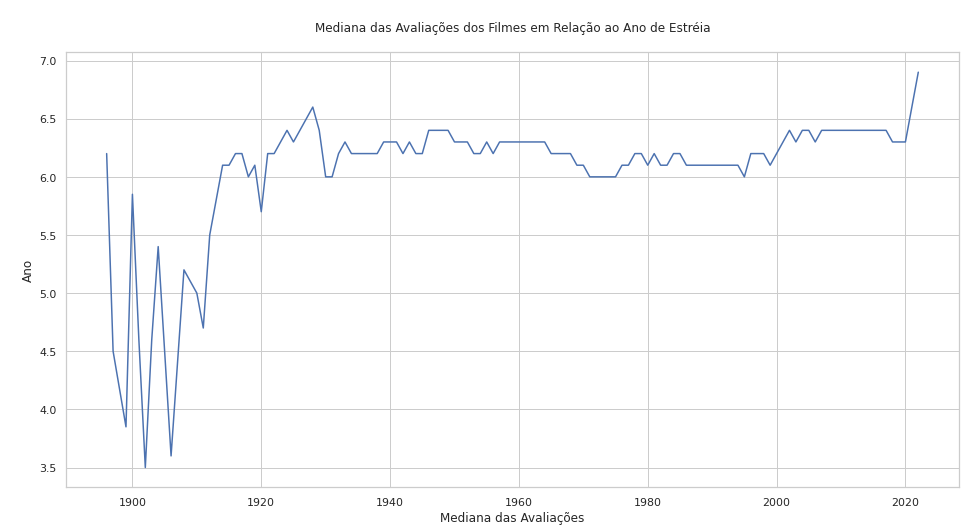

In [46]:
# Plot
plt.figure(figsize=(16, 8))
plt.plot(list(set(res4["premiered"])), ratings)
plt.ylabel("\nAno")
plt.xlabel("Mediana das Avaliações")
plt.title("\nMediana das Avaliações dos Filmes em Relação ao Ano de Estréia\n")
plt.show()


### 5 - Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?

In [47]:
query5 = '''SELECT genres FROM titles'''
res5 = pd.read_sql_query(query5, conn)
display(res5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8711514,"Action,Drama,Family"
8711515,"Action,Drama,Family"
8711516,"Action,Drama,Family"
8711517,Short


In [48]:
# Separa os gêneros únicos
unique_genres = return_genres(res5)

In [51]:
# Conta a quantidade de vezes cada gênero apareceu
genre_count = []
for item in unique_genres:
  query = "SELECT COUNT(*) COUNT FROM titles WHERE genres LIKE '%" + item + "%' AND type = 'movie' AND premiered <= 2022"
  res = pd.read_sql(query, conn)
  genre_count.append(res["COUNT"].values[0])

In [54]:
# Prepara o Dataframe
df_genre_count = pd.DataFrame()
df_genre_count["genre"] = unique_genres
df_genre_count["count"] = genre_count

In [55]:
# Calcula o Top 5
df_genre_count = df_genre_count[df_genre_count["genre"] != "n"]
df_genre_count = df_genre_count.sort_values(by="count", ascending=False)
top_genres = df_genre_count.head()["genre"].values

#### Plotando o Gráfico

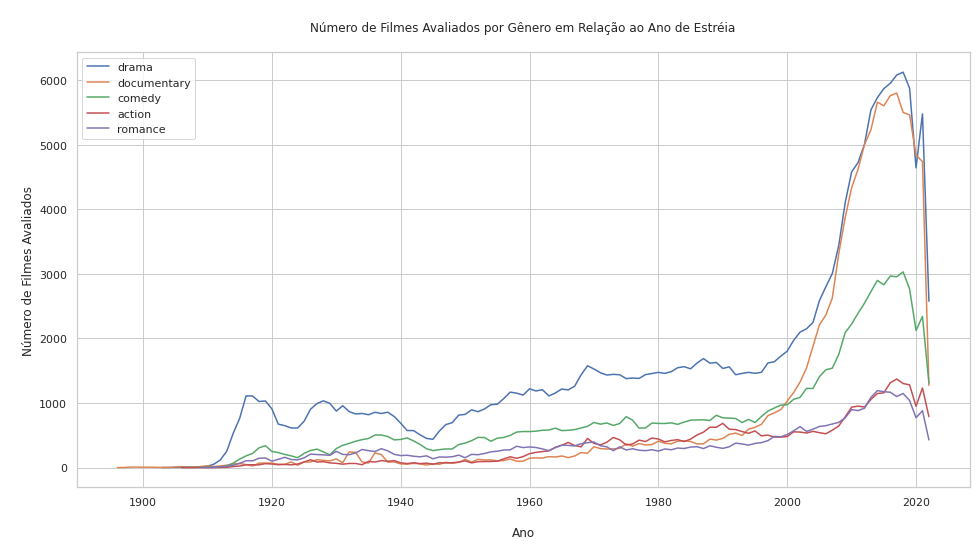

In [63]:
# Plot
plt.figure(figsize=(16, 8))

for item in top_genres:
  query = "SELECT COUNT(*) Number_Of_Movies, premiered Year FROM titles WHERE genres LIKE '%" \
          + item \
          + "%' AND type = 'movie' AND Year <= 2022 GROUP BY Year"
  res = pd.read_sql_query(query, conn)
  plt.plot(res["Year"], res["Number_Of_Movies"])

plt.xlabel("\nAno")
plt.ylabel("\nNúmero de Filmes Avaliados")
plt.title("\nNúmero de Filmes Avaliados por Gênero em Relação ao Ano de Estréia\n")
plt.legend(labels=top_genres)
plt.show()


### 6 - Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.

In [65]:
query6 = '''
            SELECT runtime_minutes Runtime FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
         '''
res6 = pd.read_sql_query(query6, conn)
display(res6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
378996,123
378997,57
378998,100
378999,116


In [67]:
for i in range(101):
  val = i
  perc = round(np.percentile(res6["Runtime"].values, val), 2)
  print("{} percentil da duração (runtime) é {}".format(val, perc))

0 percentil da duração (runtime) é 1.0
1 percentil da duração (runtime) é 45.0
2 percentil da duração (runtime) é 48.0
3 percentil da duração (runtime) é 50.0
4 percentil da duração (runtime) é 50.0
5 percentil da duração (runtime) é 52.0
6 percentil da duração (runtime) é 52.0
7 percentil da duração (runtime) é 54.0
8 percentil da duração (runtime) é 55.0
9 percentil da duração (runtime) é 56.0
10 percentil da duração (runtime) é 58.0
11 percentil da duração (runtime) é 59.0
12 percentil da duração (runtime) é 60.0
13 percentil da duração (runtime) é 60.0
14 percentil da duração (runtime) é 60.0
15 percentil da duração (runtime) é 62.0
16 percentil da duração (runtime) é 63.0
17 percentil da duração (runtime) é 65.0
18 percentil da duração (runtime) é 66.0
19 percentil da duração (runtime) é 68.0
20 percentil da duração (runtime) é 69.0
21 percentil da duração (runtime) é 70.0
22 percentil da duração (runtime) é 71.0
23 percentil da duração (runtime) é 72.0
24 percentil da duração (ru

In [71]:
# Counsulta para o filme de maior duração
query6 = '''
            SELECT runtime_minutes Runtime, primary_title FROM titles
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
         '''
res6 = pd.read_sql_query(query6, conn)
display(res6)

,Runtime,primary_title
0,51420,Logistics


"Logistics" é o filme mais longo da história (até o momento) com 857 horas de duração. Dirigido por Daniel Andersson e Erika Magnusson, o filme acompanha todos o ciclo de vida de um pedômetro (dispositivo de rastreamento de passos) em ordem cronológica reversa.


### 7 - Qual a Relação Entre Duração e Gênero?

In [73]:
query7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres FROM titles
            WHERE type = 'movie' AND runtime_minutes != 'NaN'
            GROUP BY genres
         '''
res7 = pd.read_sql_query(query7, conn)
display(res7)

,Runtime,genres
0,99.208907,Action
1,77.000000,"Action,Adult"
2,105.000000,"Action,Adult,Adventure"
3,74.000000,"Action,Adult,Comedy"
4,84.666667,"Action,Adult,Crime"
...,...,...
1361,94.266667,"Thriller,Western"
1362,94.081126,War
1363,93.636364,"War,Western"
1364,70.698681,Western


In [74]:
unique_genres = return_genres(res7)

In [75]:
# calcula duração por gênero
genre_runtime = []
for item in unique_genres:
  query = "SELECT runtime_minutes Runtime FROM titles WHERE genres LIKE '%" + item + "%' AND type = 'movie' AND Runtime != 'NaN'"
  res = pd.read_sql(query, conn)
  genre_runtime.append(np.median(res["Runtime"]))

In [76]:
# Prepara o dataframe
df_genre_runtime = pd.DataFrame()
df_genre_runtime["genre"] = unique_genres
df_genre_runtime["runtime"] = genre_runtime
display(df_genre_runtime)

,genre,runtime
0,action,94.0
1,adult,77.0
2,adventure,90.0
3,animation,81.0
4,biography,87.0
5,comedy,91.0
6,crime,92.0
7,documentary,74.0
8,drama,93.0
9,family,89.0


In [77]:
# Remove o gênero "news"
df_genre_runtime = df_genre_runtime.drop(index=18)

In [78]:
# Ordena os dados
df_genre_runtime = df_genre_runtime.sort_values(by="runtime", ascending=False)

#### Plotando o Gráfico

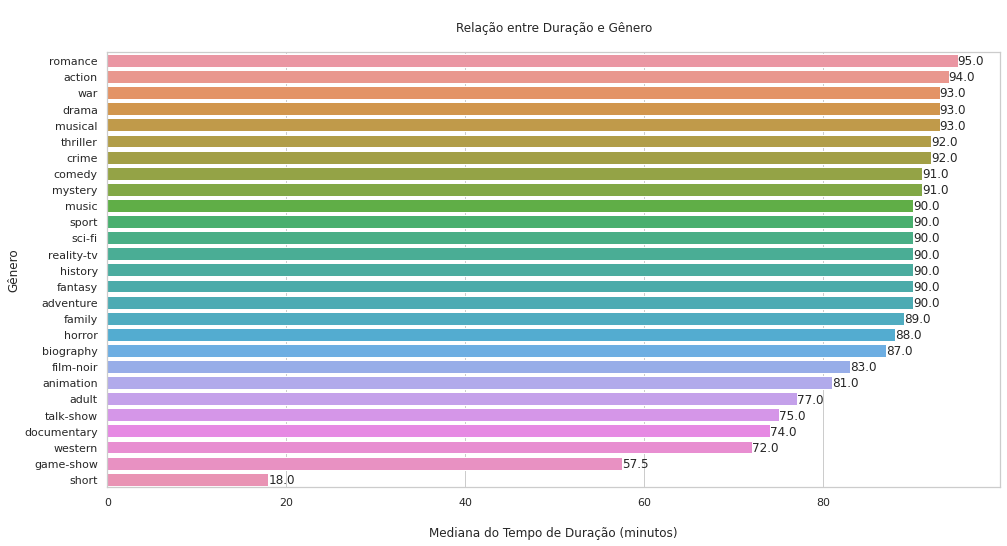

In [79]:
# Plot

plt.figure(figsize=(16, 8))

sns.barplot(y=df_genre_runtime.genre, x=df_genre_runtime.runtime, orient="h")

for i in range(len(df_genre_runtime.index)):
  plt.text(
    df_genre_runtime.runtime[df_genre_runtime.index[i]],
    i + 0.25,
    round(df_genre_runtime["runtime"][df_genre_runtime.index[i]], 2)
  )

plt.ylabel("Gênero")
plt.xlabel("\nMediana do Tempo de Duração (minutos)")
plt.title("\nRelação entre Duração e Gênero\n")
plt.show()


### 8 - Qual o Número de Filmes Produzidos Por País?

In [80]:
query8 = '''
            SELECT region, COUNT(*) Number_Of_Movies FROM akas
            JOIN titles ON akas.title_id = titles.title_id
            WHERE region != 'None' AND type = 'movie'
            GROUP BY region
         '''
res8 = pd.read_sql_query(query8, conn)
display(res8)

,region,Number_Of_Movies
0,AD,22
1,AE,5045
2,AF,110
3,AG,12
4,AL,1267
...,...,...
229,YUCS,153
230,ZA,3170
231,ZM,15
232,ZRCD,2


In [82]:
res8.shape

(234, 2)

In [83]:
# Encontra os nomes dos países
country_names = []
count = []

for i in range(res8.shape[0]):
  try:
    country_code = res8["region"].values[i]
    country_names.append(pycountry.countries.get(alpha_2 = country_code).name)
    count.append(res8["Number_Of_Movies"].values[i])
  except:
    continue


In [85]:
# Prepara o DataFrame
df_movies_countries = pd.DataFrame()
df_movies_countries["country"] = country_names
df_movies_countries["movie_count"] = count
df_movies_countries = df_movies_countries.sort_values(by="movie_count", ascending=False)

In [86]:
df_movies_countries.head(10)

,country,movie_count
199,United States,307194
65,United Kingdom,157967
96,Japan,90704
63,France,83893
89,India,79413
32,Canada,75944
47,Germany,69794
93,Italy,64921
58,Spain,64701
26,Brazil,64571


#### Plotando o Gráfico

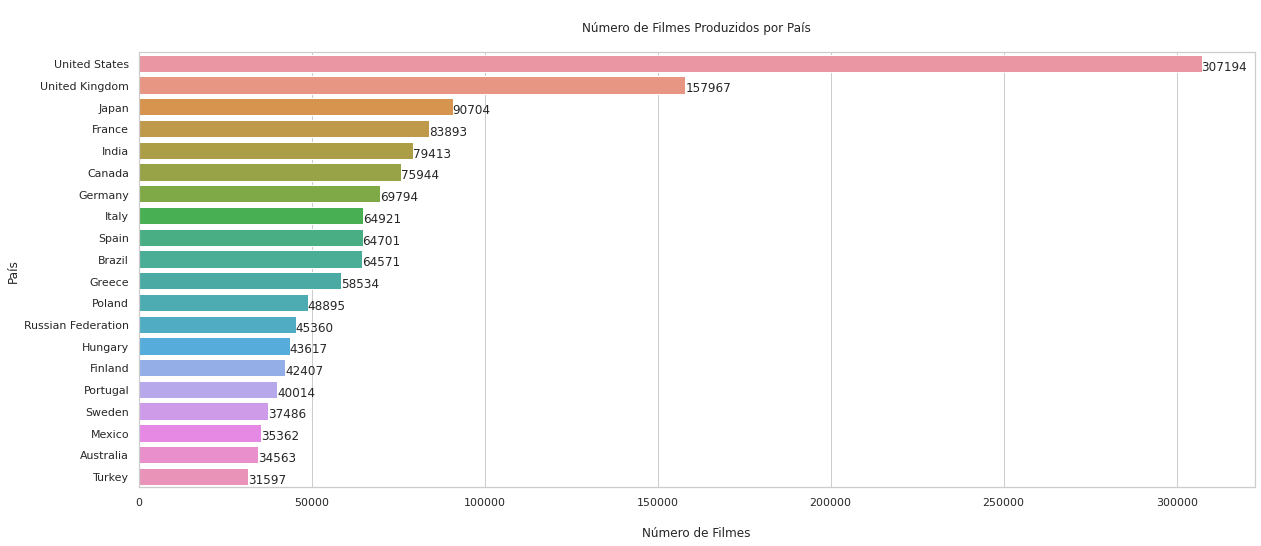

In [87]:
# Plot

plt.figure(figsize=(20, 8))

sns.barplot(y=df_movies_countries[:20].country, x=df_movies_countries[:20].movie_count, orient="h")

for i in range(0, 20):
  plt.text(
    df_movies_countries.movie_count[df_movies_countries.index[i]] - 1,
    i + 0.3,
    round(df_movies_countries["movie_count"][df_movies_countries.index[i]], 2)
  )

plt.ylabel("País")
plt.xlabel("\nNúmero de Filmes")
plt.title("\nNúmero de Filmes Produzidos por País\n")
plt.show()


### 9 - Quais São os Top 10 Melhores Filmes?

In [88]:
query9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM titles
            JOIN ratings ON titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10
         '''
top_10_best = pd.read_sql_query(query9, conn)
display(top_10_best)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,Jai Bhim,"Crime,Drama,Mystery",9.3
3,The Godfather,"Crime,Drama",9.2
4,Soorarai Pottru,Drama,9.1
5,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
6,Mirror Game,"Crime,Mystery,Thriller",9.1
7,12 Angry Men,"Crime,Drama",9.0
8,The Godfather: Part II,"Crime,Drama",9.0
9,The Dark Knight,"Action,Crime,Drama",9.0



### 10 - Quais São os Top 10 Piores Filmes?

In [89]:
query10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM titles
            JOIN ratings ON titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
         '''
top_10_worst = pd.read_sql_query(query10, conn)
display(top_10_worst)

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Sadak 2,"Action,Drama",1.1
2,Smolensk,"Drama,Thriller",1.2
3,Reis,"Biography,Drama",1.4
4,The Cost of Deception,"Crime,Drama,History",1.5
5,Justin Bieber: Never Say Never,"Documentary,Music",1.6
6,Manos: The Hands of Fate,Horror,1.8
7,Radhe,"Action,Crime,Thriller",1.8
8,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9
